In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report

# Preparing The Data

In [2]:
!git clone https://github.com/mvaldenegro/marine-debris-fls-datasets.git

Cloning into 'marine-debris-fls-datasets'...
remote: Enumerating objects: 13207, done.
remote: Total 13207 (delta 0), reused 0 (delta 0), pack-reused 13207 (from 1)
Receiving objects: 100% (13207/13207), 224.31 MiB | 14.54 MiB/s, done.
Resolving deltas: 100% (2170/2170), done.
Updating files: 100% (12921/12921), done.


In [3]:
import pathlib
data_dir="/content/marine-debris-fls-datasets/md_fls_dataset/data/watertank-cropped"
data_dir = pathlib.Path(data_dir)

In [4]:
print(data_dir)

/content/marine-debris-fls-datasets/md_fls_dataset/data/watertank-cropped


/content/marine-debris-fls-datasets/md_fls_dataset/data/watertank-cropped/bottle/bottle-38.png


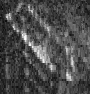

In [5]:
bottle = list(data_dir.glob('bottle/*'))
print(bottle[0])
PIL.Image.open(str(bottle[0]))

In [6]:
img_height,img_width=224,224
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.7,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2364 files belonging to 10 classes.
Using 710 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2364 files belonging to 10 classes.
Using 709 files for validation.


In [8]:
img_height, img_width = 224, 224
batch_size = 32

# Train (70%) et Val (20%) avec seed=123
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,  # Split global de 30% pour isoler Val + Test
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Test (10%) avec seed=123 pour cohérence
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,  # Split final de 10% exclusif
    subset="validation",
    seed=123,  # Même graine pour éviter le chevauchement
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2364 files belonging to 10 classes.
Using 1655 files for training.
Found 2364 files belonging to 10 classes.
Using 709 files for validation.
Found 2364 files belonging to 10 classes.
Using 236 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['bottle', 'can', 'chain', 'drink-carton', 'hook', 'propeller', 'shampoo-bottle', 'standing-bottle', 'tire', 'valve']


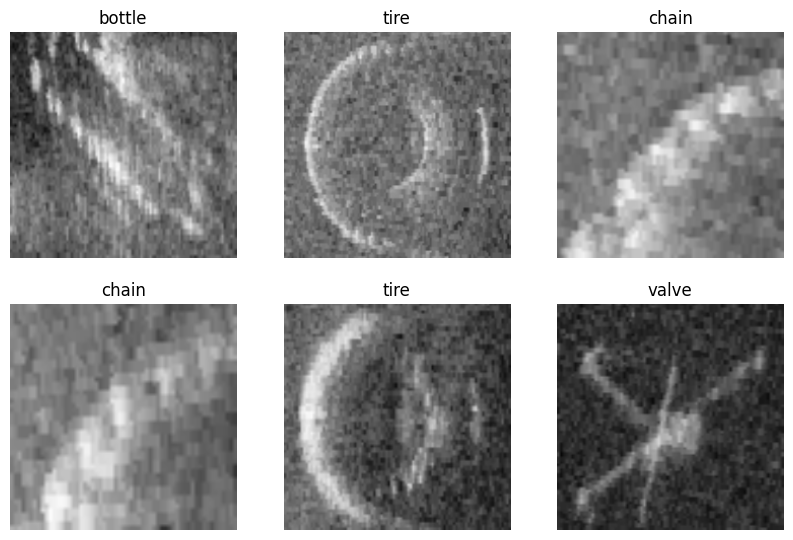

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Training The Model


In [11]:
# Extract the features
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Classifier (standard neural network)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)


- D’abord, deux couches Conv2D appliquent des filtres (16 puis 32) pour détecter des motifs comme les contours et les textures.
- Après chaque convolution, une couche MaxPooling réduit la taille des images pour garder uniquement les informations essentielles et accélérer l’apprentissage.
- Une couche GlobalAveragePooling2D prend tout ce qui a été extrait et le résume en une représentation plus compacte.
- Deux couches denses (128 neurones chacune, avec activation ReLU) analysent ces informations et cherchent à établir des relations plus complexes.
- Enfin, la dernière couche softmax transforme tout ça en probabilités pour déterminer à quelle catégorie appartient l’image parmi les 10 possibles.


In [12]:

# Create the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)


Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 14s 155ms/step - accuracy: 0.1471 - loss: 4.7999 - val_accuracy: 0.2440 - val_loss: 1.9894
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.2436 - loss: 1.9361 - val_accuracy: 0.3004 - val_loss: 1.7987
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.2834 - loss: 1.8019 - val_accuracy: 0.2694 - val_loss: 1.9881
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.2965 - loss: 1.8002 - val_accuracy: 0.4048 - val_loss: 1.4615
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.3566 - loss: 1.5550 - val_accuracy: 0.4133 - val_loss: 1.4254
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.3949 - loss: 1.4638 - val_accuracy: 0.4231 - val_loss: 1.5346
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.4044 - loss: 1.4487 - val_accuracy: 0.5120 - val_loss: 1.2798
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.4507 - loss: 1.3285 - val_accuracy: 

# Evaluating The Model

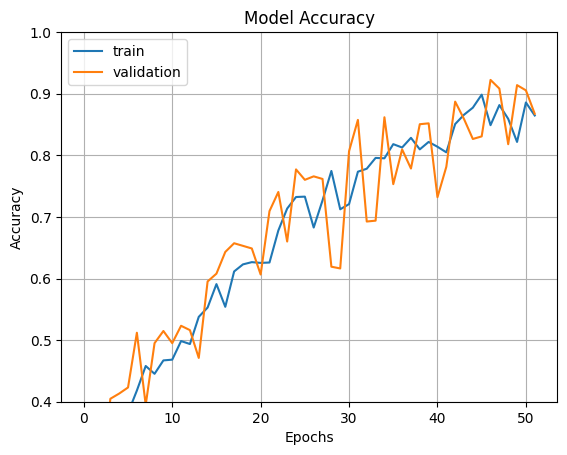

In [13]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

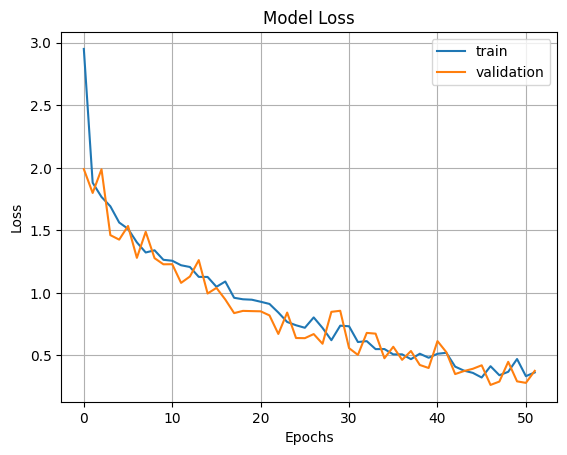

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [15]:
# Print accuracy (Percentage of correct predictions)
results = model.evaluate(test_ds, verbose=0)
print("Accuracy: {:.2f} %".format(results[1] * 100))

Accuracy: 91.95 %


In [16]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

# Récupération des vraies étiquettes du dataset
true_labels = []
predicted_labels = []
for images, labels in test_ds:
    true_labels.extend(labels.numpy())  # Stocker les vraies classes
    predictions = model.predict(images)  # Prédictions en probabilités
    predicted_labels.extend(np.argmax(predictions, axis=1))  # Prendre la classe avec proba max

# Convertir en tableau numpy
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Matrice de confusion
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", cm)

# Rapport de classification
clr = classification_report(true_labels, predicted_labels, target_names=test_ds.class_names)
print("Classification Report:\n", clr)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
Confusion Matrix:
 [[48  2  0  0  0  0  0  0  0  1]
 [ 0 32  0  1  0  1  0  0  0  0]
 [ 0  2 19  2  0  0  0  0  0  0]
 [ 0  3  3 31  0  0  0  0  0  0]
 [ 0  0  0  0 14  0  0  0  0  0]
 [ 0  0  0  0  0 14  0  0  0  0]
 [ 0  0  0  0  0  0  6  0  0  0]
 [ 0  0  0  0  0  0  0  8  0  0]
 [ 2  0  0  0  0  0  0  0 30  1]
 [ 0  0  0  0  0  0  0  0  1 15]]
Classification Report:
                  precision    recall  f1-score   support

         bottle       0.96      0.94      0.95        51
            can       0.82      0.94      0.88        34
          chain       0.86      0.83      0.84        23
   drink-carton       0.91      0.84      0.87        37
           hook       1.00      1.

# Making Predictions

(1, 224, 224, 3)


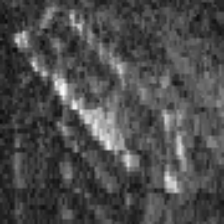

In [17]:
import cv2
image=cv2.imread(str(bottle[0]))
image_resized= cv2.resize(image, (img_height,img_width))
image=np.expand_dims(image_resized,axis=0)
print(image.shape)
PIL.Image.fromarray(image_resized)

In [18]:
pred=model.predict(image)
print(pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
[[7.7645159e-01 2.2355849e-07 1.5635249e-09 1.5849980e-07 9.7948805e-09
  6.3126045e-08 1.0004922e-08 9.6331977e-11 1.8092638e-01 4.2621568e-02]]


In [19]:
output_class=class_names[np.argmax(pred)]
print("The predicted class is", output_class)

The predicted class is bottle
